In [3]:
import sys
sys.path.append('../')

import os
import mmgclip
import torch
import numpy as np
from hydra import compose, initialize
from omegaconf import DictConfig, OmegaConf
from attrdict import AttrDict
from mmgclip.prompts.enums import * # import all enums, get the required using globals().get('...')
from mmgclip.utils.data_utils import process_class_list
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.special import softmax
import seaborn as sns
import pandas as pd

torch.cuda.empty_cache() 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sns.set_theme(style="white", palette="coolwarm")

# for auto reload when changes are made in the package
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def compare_models_performance(evaluation_config: dict = {}):

    # create a shared plot 
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # experiments dataframe
    df_data = {}

    # iterate over all experiments to load the models
    for experiment in evaluation_config['experiments']:
        # model specific placeholders
        image_features = []
        image_embeddings = []
        text_embeddings = []
        label_names = []
        prompt_labels = []
        roc_curves = []
        df_data[f'{experiment["legend_label"]}'] = []

        # prepare the model config
        with initialize(config_path=os.path.join(evaluation_config['config_dir'], experiment['path'], '.hydra')):
            cfg = compose(config_name='config')

        # set this once outside to evaluate all models using the same dataset
        cfg['dataset']['eval']['dataset']['name'] = evaluation_config['dataset']['name']
        cfg['dataset']['eval']['enum_classes'] = evaluation_config['dataset']['enum_classes']

        # prepare the config
        cfg['dataset']['config']['lists_dataset_path'] = "../data/02_data_lists/data/lists"
        cfg['dataset']['config']['annotated_dataset_path'] = "../data/02_data_T_regions"
        cfg['base']['export_dir'] = f'../outputs/{experiment["path"]}'
        cfg['base']['features_export_dir'] = '../outputs/dataset'
        cfg['base']['results_export_dir'] = f'../outputs/{experiment["path"]}/.'

        if not experiment['cnn_eval']:
            cfg['checkpoints']['checkpoints_export_dir'] = f'../outputs/{experiment["path"]}/checkpoints'
        
        try:
            # use in try except, those configs are only for exam-prompt config file, avoid the error of other configs using try except
            post_translation_fileid = cfg['dataset']['config']['post_translation_fileid']
            cfg['dataset']['config']['final_reports_dataset_path'] = f"../data/{post_translation_fileid}/final_reports_dataset.csv"
            cfg['dataset']['config']['eliminated_reports_path'] = f"../data/reports_lists/eliminate.csv"
            cfg['dataset']['config']['raw_path'] =  "../data/reports/Radboud02_ParadigmArchiveCorrespondance.csv"
            cfg['dataset']['config']['gt_path'] =  "../data/reports/Radboud_findings_Case_gtr.csv"
            cfg['dataset']['config']['post_translation_dataset_path'] = f"../data/{post_translation_fileid}/postprocessed_tr_dataset.csv"
        except Exception as e:
            pass

        mmgconfig = AttrDict(cfg)

        if not experiment['cnn_eval']:
            # load the ckp file
            ckp_path = os.path.join(mmgconfig.checkpoints.checkpoints_export_dir, mmgconfig.checkpoints.checkpoints_file_name)
            ckp_file = torch.load(ckp_path)

            # load the model, and the state_dict and set to eval
            model = mmgclip.model(config=mmgconfig).to(device)
            model.load_state_dict(ckp_file['model_state_dict'])
            model.eval()
        else:
            assert evaluation_config['evaluation']['type'] == "ova", "CNN Encoder can only be evaluated using `ova` method."
            model = torch.jit.load(os.path.join("../", mmgconfig.networks.image_encoder.convnext_tiny_clf_path))
            model.eval()

        # set the seeding
        mmgclip.seeding(evaluation_config['seed'])

        # load the dataset, all experiments are validated using the same dataset
        clf_dataset = mmgclip.get_dataset(dataset_name=cfg['dataset']['eval']['dataset']['name'])(config=mmgconfig)
        _, val_clf_split = clf_dataset.random_split(dataset=clf_dataset, split='train')
        _, test_clf_split = clf_dataset.random_split(dataset=val_clf_split, split='test')

        # load the test dataloader
        test_dataloader = mmgclip.DataLoaders(config=mmgconfig, dataset_split=test_clf_split).get_dataloader(
            **mmgconfig.dataloader.test,
            collate_fn=clf_dataset.collate_fn,
            )

        # we will re-use some functions in the evaluator
        evaluator = mmgclip.Evaluator(
            config=mmgconfig, 
            test_dataloader=test_dataloader,
            tokenizer = clf_dataset.tokenizer,
            cnn_eval = experiment['cnn_eval'])

        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                label_names.extend(batch['image_description'])
                image_features.extend(batch['image_features'])
                prompt_labels.extend(batch['prompt_labels'])

                if not experiment['cnn_eval']:
                    image_embeddings.append(evaluator.encode_image(batch))
                    text_embeddings.append(evaluator.encode_text(batch))

            if not experiment['cnn_eval']:
                image_embeddings = np.concatenate(image_embeddings, axis=0)
                text_embeddings = np.concatenate(text_embeddings, axis=0)

            image_features = torch.stack(image_features, dim=0) # (torch.Size([iterations x n, 1, 768, 1, 1]),) 

            EnumClass = globals().get(mmgconfig.dataset.eval.enum_classes[0])
            classes_dict = {label.name: label.value for label in EnumClass}

            #  obtainthe unique label names
            label_names = [process_class_list([label[mmgconfig.dataset.eval.enum_classes[0]]]) for label in prompt_labels] # y_true
            
            # obtain the classes labels as prompts
            classes_prompts = process_class_list(list(classes_dict.keys()))

            if evaluation_config['evaluation']['type'] == "ova":
                if not experiment['cnn_eval']:
                    for class_name in classes_prompts:
                        class_prompt = [class_name]
                        # structure the input
                        inputs = {
                            "image_features": image_features,
                            "text_tokens": evaluator.tokenizer(class_prompt, padding="max_length", truncation=True, return_tensors="pt", max_length=model.config.tokenizer.config.sequence_length)
                        }   

                        # we plot the roc using the logits directly, no need for a softmax as the softmax will return [1] for each row sample
                        similarities = model(inputs, validation=True)['logits_per_image']

                        # cast similarities to numpy
                        similarities = similarities.detach().cpu().numpy()

                        # obtain the y_true from the dataset
                        y_true = np.array([1 if class_name in label else 0 for label in label_names])

                        # obtain the metrics
                        fpr, tpr, thresholds = metrics.roc_curve(y_true, similarities[:, 0])
                        roc  = metrics.auc(fpr, tpr)

                        roc_curves.append((fpr, tpr))

                        df_data[f'{experiment["legend_label"]}'].append(roc)
                        
                else:
                    similarities = []

                    for i in range(image_features.size(0)):
                        # Access the slice along the first axis
                        sample_feature = image_features[i]

                        # Squeeze along the second dimension
                        sample_feature = torch.squeeze(sample_feature, dim=1)  
                            
                        logits = model.classifier(sample_feature)

                        similarities.append(softmax(logits / 2))

                    similarities = np.concatenate(similarities, axis=0)   

                    for idx, class_name in enumerate(classes_prompts):
                        # obtain the y_true
                        y_true = np.array([1 if class_name in label else 0 for label in label_names])

                        # obtain the metrics
                        fpr, tpr, thresholds = metrics.roc_curve(y_true, similarities[:, idx])
                        roc  = metrics.auc(fpr, tpr)

                        roc_curves.append((fpr, tpr))
                        df_data[f'{experiment["legend_label"]}'].append(roc)
    
            elif evaluation_config['evaluation']['type'] == "zeroshot_label_prompt":
                # get the specific label sentence
                if mmgconfig.dataset.eval.enum_classes[0] == "BenignMalignantDatasetLabels":
                    prompts = [f"Finding suggesting {label}." for label in classes_prompts]
                elif mmgconfig.dataset.eval.enum_classes[0] == "MassShapeLabels":
                    prompts = [f"Mass shape is {label}." for label in classes_prompts]
                elif mmgconfig.dataset.eval.enum_classes[0] == "MassMarginLabels":
                    prompts = [f"Mass margin is {label}." for label in classes_prompts]
                
                # pass to the tokenizer and encoder
                text_embeddings = evaluator.encode_text(prompts)

                if evaluation_config['evaluation']['zeroshot_use_logits']:
                    # similarities here are the logits per image same as the computation of the model forward pass
                    logit_scale = model.logit_scale.exp()
                    logit_scale = logit_scale.detach().cpu().numpy()

                    similarities = logit_scale * image_embeddings @ np.transpose(text_embeddings)
                else:
                    similarities = metrics.pairwise.cosine_similarity(image_embeddings, text_embeddings) # [samples, n_classes]

                # obtain a normalized probabilities/predictions
                similarities = softmax(similarities, axis=1)

                # obtain y-true from the dataset
                y_true = np.array([classes_dict[label[0].replace(' ', '')] for label in label_names])

                # apply argmax to find the highest probability predictions
                # y_pred = np.argmax(similarities, axis=-1) #torch.argmax(similarities, dim=-1).detach().cpu().numpy()

                for idx, value in enumerate(prompts):
                    # change roc_curve to roc_auc_score
                    roc = metrics.roc_auc_score(y_true == idx, similarities[:, idx])
                    fpr, tpr, thresholds = metrics.roc_curve(y_true == idx, similarities[:, idx])

                    roc_curves.append((fpr, tpr))
                    df_data[f'{experiment["legend_label"]}'].append(roc)

            # Interpolation
            mean_fpr = np.linspace(0, 1, 100)

            tprs = []
            for fpr, tpr in roc_curves:
                tprs.append(np.interp(mean_fpr, fpr, tpr))

            # Calculate mean and std
            mean_tpr = np.mean(tprs, axis=0)
            std_tpr = np.std(tprs, axis=0)

            # Calculate AUC
            mean_auc = metrics.auc(mean_fpr, mean_tpr)

            # Plotting roc curves
            axes[1].plot(mean_fpr, mean_tpr, color=experiment['line_color'], linewidth=1, label=f'{experiment["legend_label"]}, Mean AUC = {mean_auc:.4f}')
            axes[1].fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color=experiment['fill_color'], alpha=0.2) # label='± 1 std. dev.'

    axes[1].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    # axes[1].xlim([0.0, 1.0])
    # axes[1].ylim([0.0, 1.05])
    # axes[1].xlabel('False Positive Rate')
    # axes[1].ylabel('True Positive Rate')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    # axes[1].title(evaluation_config['plot_title'])
    axes[1].set_title(evaluation_config['plot_title'])

    axes[1].legend(loc="lower right")
    # axes[1].show()

    # df for boxplot
    df = pd.DataFrame(df_data, index=classes_prompts)
    columns = df.columns.tolist()

    # plot the boxplot
    boxplot = df.boxplot(column=columns, rot=90, ax=axes[0])

    axes[0].set_title('Boxplot of Models Performance')
    axes[0].set_xlabel('Models')
    axes[0].set_ylabel('AUC')

    plt.show()


ckp_path: ../outputs/2024-04-26/11-45-30/checkpoints/model.pth


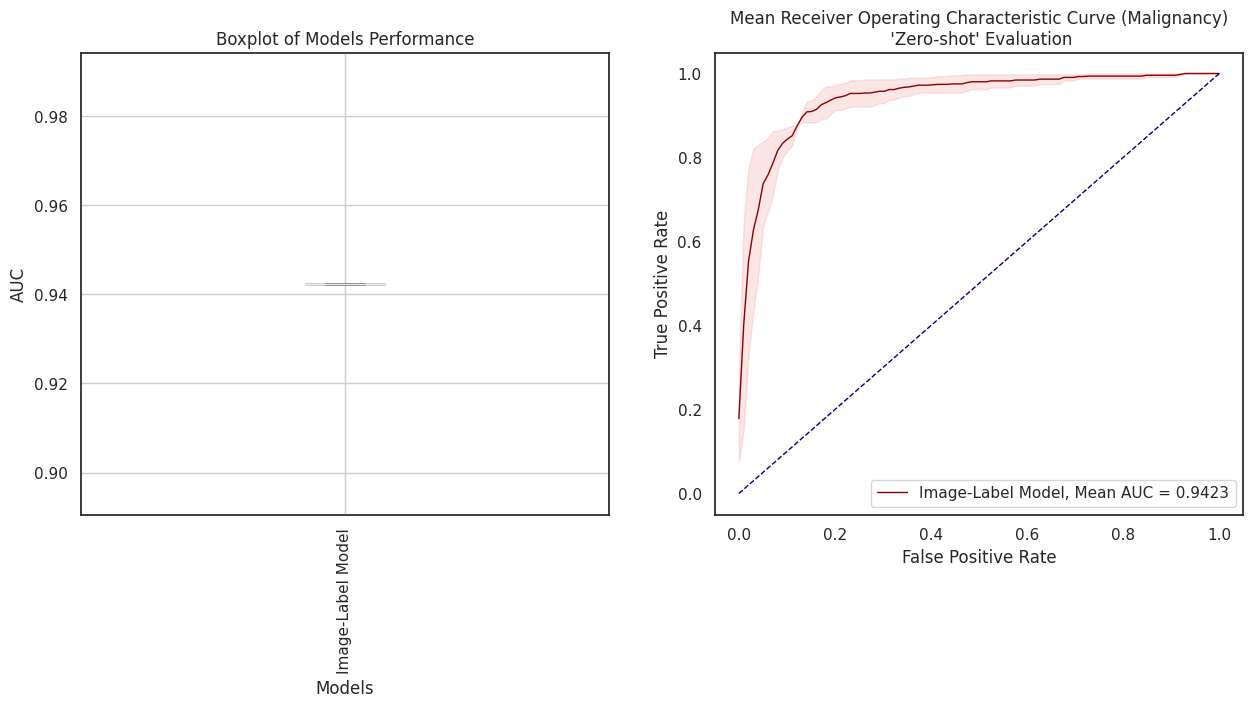

In [5]:
evaluation_config = {
    "seed": 42,
    "evaluation": {
        "type": "zeroshot_label_prompt",    # one of ["ova", "zeroshot_label_prompt"]
        "zeroshot_use_logits": True         # only used with zeroshot evaluation
    },
    "experiments":[
        {
            "path": "2024-04-26/11-45-30",  # MMG-CLIP n=32, 1xLinear512, Image-Label, Benign vs Malignant
            "legend_label": "Image-Label Model",
            "line_color": "darkred",
            "fill_color": "lightcoral",
            "cnn_eval": False
        },
        # {
        #     "path": "2024-04-23/15-40-44",  # MMG-CLIP n=32, 1xLinear512, Image-Prompt
        #     "legend_label": "Image-Prompt",
        #     "line_color": "g",
        #     "fill_color": "lightgreen",
        #     "cnn_eval": False
        # },
        # {
        #     "path": "2024-04-22/14-24-15",
        #     "legend_label": "Exam-Report Model",
        #     "line_color": "k",
        #     "fill_color": "lightgrey",
        #     "cnn_eval": False
        # },
    ],
    "dataset": {
        "name": "ImageLabelDataset",        # one of ["ImageLabelDataset"]
        "enum_classes": ['BenignMalignantDatasetLabels']
    },
    "plot_title": "Mean Receiver Operating Characteristic Curve (Malignancy)\n 'Zero-shot' Evaluation",
    "config_dir": "../outputs/"
}

compare_models_performance(evaluation_config)

ckp_path: ../outputs/2024-04-26/11-45-30/checkpoints/model.pth


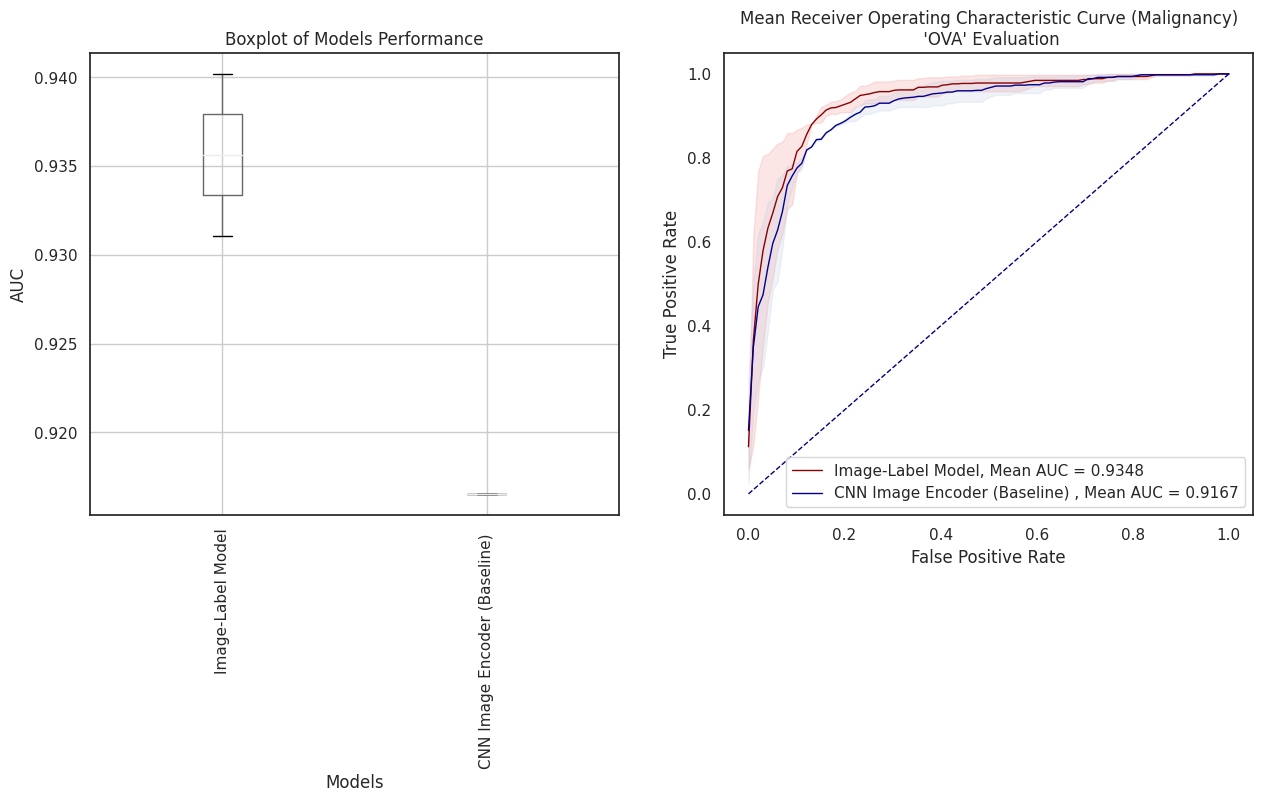

In [4]:
evaluation_config = {
    "seed": 42,
    "evaluation": {
        "type": "ova",    # one of ["ova", "zeroshot_label_prompt"]
        "zeroshot_use_logits": True         # only used with zeroshot evaluation
    },
    "experiments":[
        {
            "path": "2024-04-26/11-45-30",  # MMG-CLIP n=32, 1xLinear512, Image-Label, Benign vs Malignant
            "legend_label": "Image-Label Model",
            "line_color": "darkred",
            "fill_color": "lightcoral",
            "cnn_eval": False
        },
        {   # Image Encoder CNN (Baseline) n=32, Image-Label, Benign vs Malignant; Note here we evaluate as ova
            "path": "2024-04-22/13-14-08",
            "legend_label": "CNN Image Encoder (Baseline) ",
            "line_color": "darkblue",
            "fill_color": "lightsteelblue",
            "cnn_eval": True
        },
        # {
        #     "path": "2024-04-23/15-40-44",  # MMG-CLIP n=32, 1xLinear512, Image-Prompt
        #     "legend_label": "Image-Prompt",
        #     "line_color": "g",
        #     "fill_color": "lightgreen",
        #     "cnn_eval": False
        # },
        # {
        #     "path": "2024-04-22/14-24-15",
        #     "legend_label": "Exam-Report Model",
        #     "line_color": "k",
        #     "fill_color": "lightgrey",
        #     "cnn_eval": False
        # },
    ],
    "dataset": {
        "name": "ImageLabelDataset",        # one of ["ImageLabelDataset"]
        "enum_classes": ['BenignMalignantDatasetLabels']
    },
    "plot_title": "Mean Receiver Operating Characteristic Curve (Malignancy)\n 'OVA' Evaluation",
    "config_dir": "../outputs/"
}

compare_models_performance(evaluation_config)

ckp_path: ../outputs/2024-04-22/13-48-41/checkpoints/model.pth
ckp_path: ../outputs/2024-04-23/15-40-44/checkpoints/model.pth
ckp_path: ../outputs/2024-04-22/14-24-15/checkpoints/model.pth


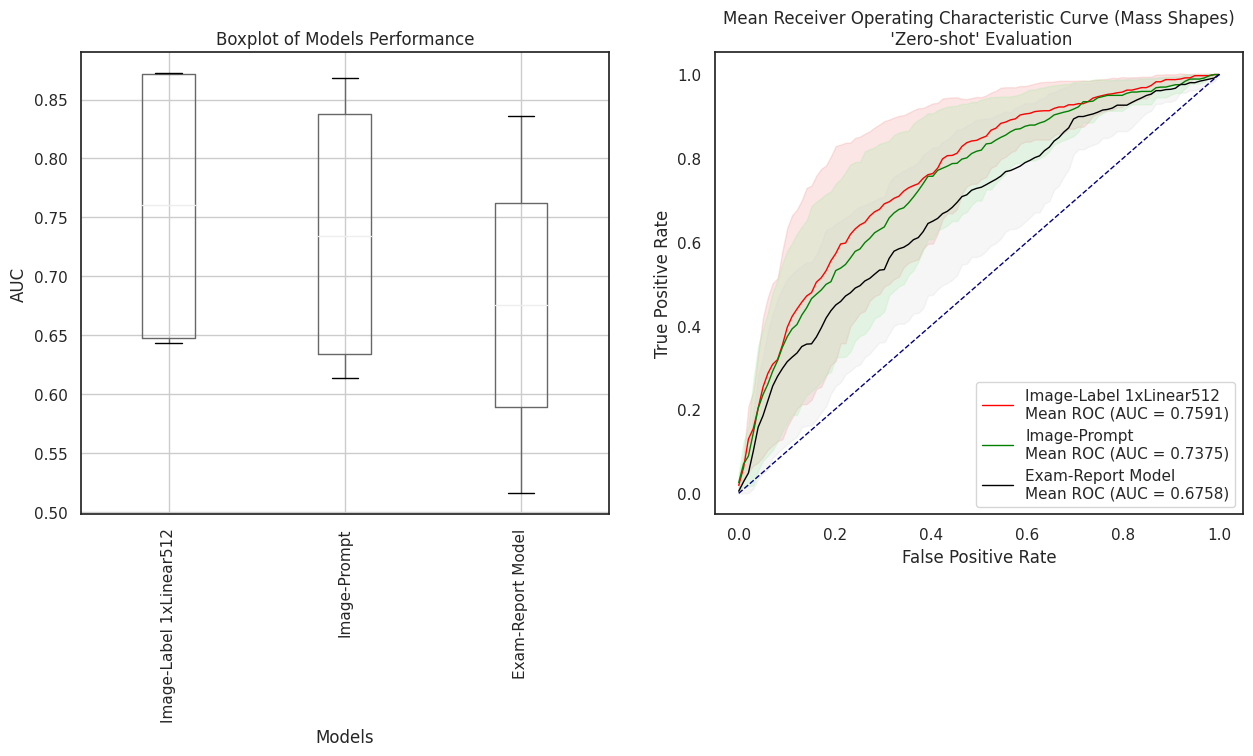

In [9]:
evaluation_config = {
    "seed": 42,
    "evaluation": {
        "type": "zeroshot_label_prompt",    # one of ["ova", "zeroshot_label_prompt"]
        "zeroshot_use_logits": True         # only used with zeroshot evaluation
    },
    "experiments":[
        {
            "path": "2024-04-26/12-00-42",  # MMG-CLIP n=32, 1xLinear512, Image-Label, Mass Shapes
            "legend_label": "Image-Label Model",
            "line_color": "darkred",
            "fill_color": "lightcoral",
            "cnn_eval": False
        },
        # {
        #     "path": "2024-04-23/15-40-44",  # MMG-CLIP n=32, 1xLinear512, Image-Prompt
        #     "legend_label": "Image-Prompt",
        #     "line_color": "g",
        #     "fill_color": "lightgreen",
        #     "cnn_eval": False
        # },
        # {
        #     "path": "2024-04-22/14-24-15",
        #     "legend_label": "Exam-Report Model",
        #     "line_color": "k",
        #     "fill_color": "lightgrey",
        #     "cnn_eval": False
        # },
    ],
    "dataset": {
        "name": "ImageLabelDataset",        # one of ["ImageLabelDataset"]
        "enum_classes": ['MassShapeLabels']
    },
    "plot_title": "Mean Receiver Operating Characteristic Curve (Mass Shapes)\n 'Zero-shot' Evaluation",
    "config_dir": "../outputs/"
}

compare_models_performance(evaluation_config)

ckp_path: ../outputs/2024-04-22/13-48-41/checkpoints/model.pth
ckp_path: ../outputs/2024-04-23/15-40-44/checkpoints/model.pth
ckp_path: ../outputs/2024-04-22/14-24-15/checkpoints/model.pth


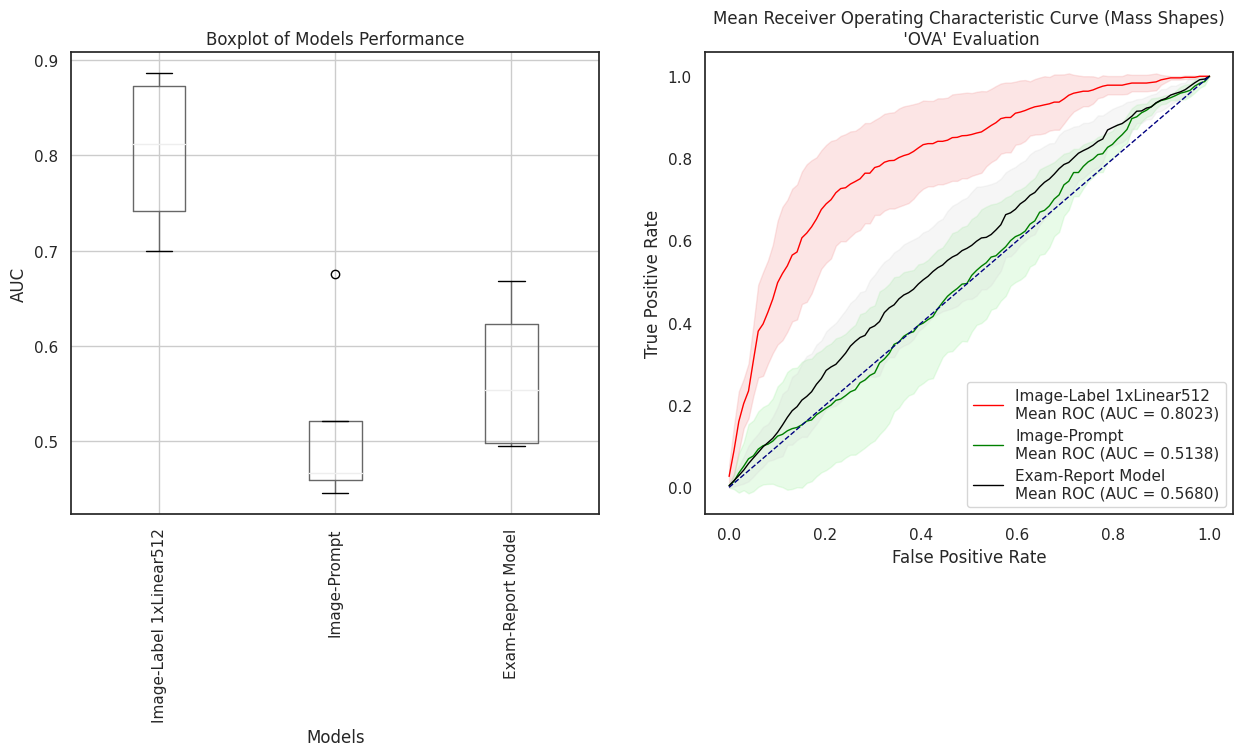

In [10]:
evaluation_config = {
    "seed": 42,
    "evaluation": {
        "type": "ova",    # one of ["ova", "zeroshot_label_prompt"]
        "zeroshot_use_logits": True         # only used with zeroshot evaluation
    },
    "experiments":[
        {
            "path": "2024-04-26/12-00-42",  # MMG-CLIP n=32, 1xLinear512, Image-Label, Mass Shapes
            "legend_label": "Image-Label Model",
            "line_color": "darkred",
            "fill_color": "lightcoral",
            "cnn_eval": False
        },
        {
            "path": "2024-04-23/15-40-44",  # MMG-CLIP n=32, 1xLinear512, Image-Prompt
            "legend_label": "Image-Prompt",
            "line_color": "g",
            "fill_color": "lightgreen",
            "cnn_eval": False
        },
        {
            "path": "2024-04-22/14-24-15",
            "legend_label": "Exam-Report Model",
            "line_color": "k",
            "fill_color": "lightgrey",
            "cnn_eval": False
        },
    ],
    "dataset": {
        "name": "ImageLabelDataset",        # one of ["ImageLabelDataset"]
        "enum_classes": ['MassShapeLabels']
    },
    "plot_title": "Mean Receiver Operating Characteristic Curve (Mass Shapes)\n 'OVA' Evaluation",
    "config_dir": "../outputs/"
}

compare_models_performance(evaluation_config)

ckp_path: ../outputs/2024-04-22/14-16-42/checkpoints/model.pth
ckp_path: ../outputs/2024-04-23/15-40-44/checkpoints/model.pth
ckp_path: ../outputs/2024-04-22/14-24-15/checkpoints/model.pth


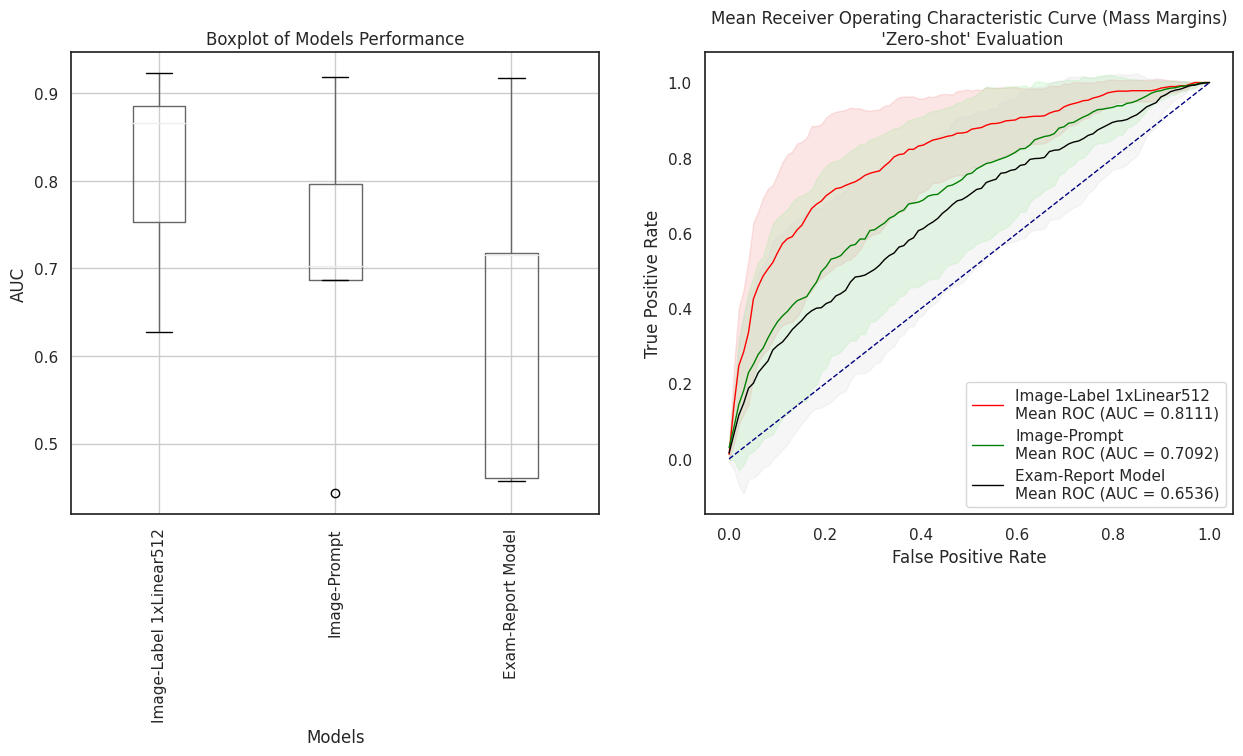

In [12]:
evaluation_config = {
    "seed": 42,
    "evaluation": {
        "type": "zeroshot_label_prompt",    # one of ["ova", "zeroshot_label_prompt"]
        "zeroshot_use_logits": True         # only used with zeroshot evaluation
    },
    "experiments":[
        {
            "path": "2024-04-26/11-54-33",  # MMG-CLIP n=32, 1xLinear512, Image-Label, Mass Margins
            "legend_label": "Image-Label Model",
            "line_color": "darkred",
            "fill_color": "lightcoral",
            "cnn_eval": False
        },
        # {
        #     "path": "2024-04-23/15-40-44",  # MMG-CLIP n=32, 1xLinear512, Image-Prompt
        #     "legend_label": "Image-Prompt",
        #     "line_color": "g",
        #     "fill_color": "lightgreen",
        #     "cnn_eval": False
        # },
        # {
        #     "path": "2024-04-22/14-24-15",
        #     "legend_label": "Exam-Report Model",
        #     "line_color": "k",
        #     "fill_color": "lightgrey",
        #     "cnn_eval": False
        # },
    ],
    "dataset": {
        "name": "ImageLabelDataset",        # one of ["ImageLabelDataset"]
        "enum_classes": ['MassMarginLabels']
    },
    "plot_title": "Mean Receiver Operating Characteristic Curve (Mass Margins)\n 'Zero-shot' Evaluation",
    "config_dir": "../outputs/"
}

compare_models_performance(evaluation_config)

ckp_path: ../outputs/2024-04-22/14-16-42/checkpoints/model.pth
ckp_path: ../outputs/2024-04-23/15-40-44/checkpoints/model.pth
ckp_path: ../outputs/2024-04-22/14-24-15/checkpoints/model.pth


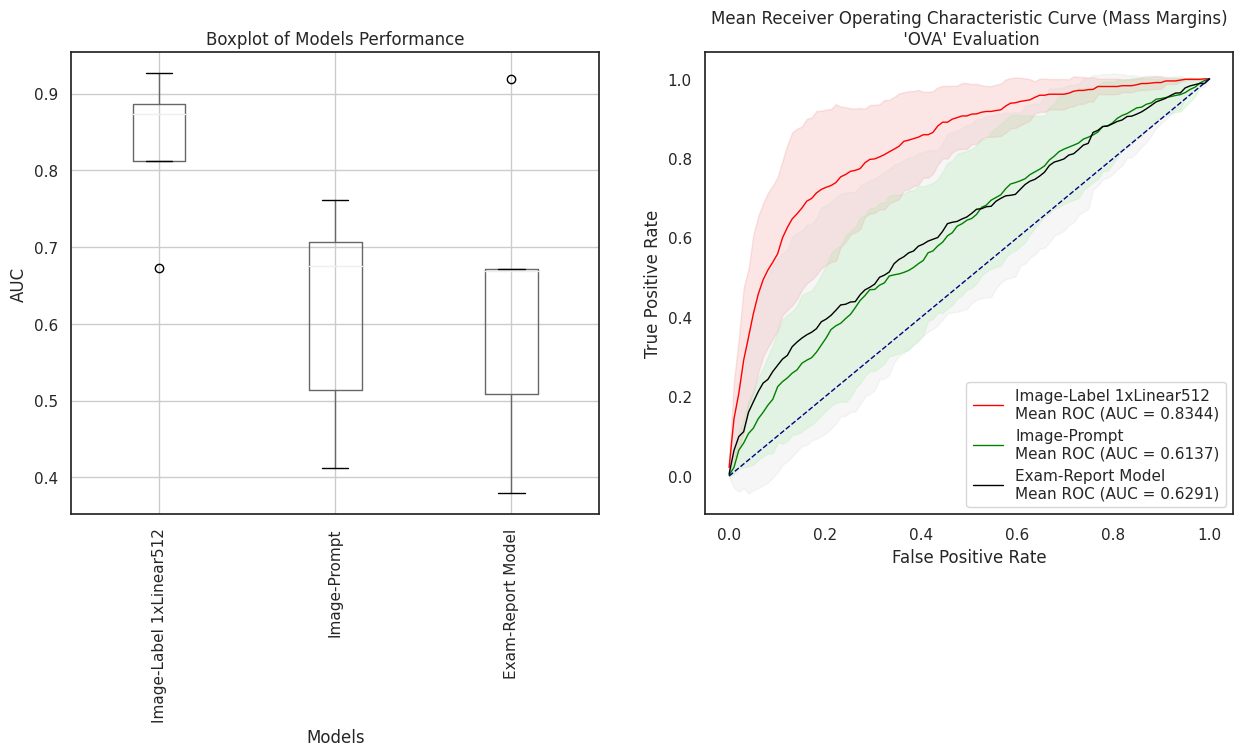

In [11]:
evaluation_config = {
    "seed": 42,
    "evaluation": {
        "type": "ova",    # one of ["ova", "zeroshot_label_prompt"]
        "zeroshot_use_logits": True         # only used with zeroshot evaluation
    },
    "experiments":[
        {
            "path": "2024-04-26/11-54-33",  # MMG-CLIP n=32, 1xLinear512, Image-Label, Mass Margins
            "legend_label": "Image-Label Model",
            "line_color": "darkred",
            "fill_color": "lightcoral",
            "cnn_eval": False
        },
        {
            "path": "2024-04-23/15-40-44",  # MMG-CLIP n=32, 1xLinear512, Image-Prompt
            "legend_label": "Image-Prompt",
            "line_color": "g",
            "fill_color": "lightgreen",
            "cnn_eval": False
        },
        {
            "path": "2024-04-22/14-24-15",
            "legend_label": "Exam-Report Model",
            "line_color": "k",
            "fill_color": "lightgrey",
            "cnn_eval": False
        },
    ],
    "dataset": {
        "name": "ImageLabelDataset",        # one of ["ImageLabelDataset"]
        "enum_classes": ['MassMarginLabels']
    },
    "plot_title": "Mean Receiver Operating Characteristic Curve (Mass Margins)\n 'OVA' Evaluation",
    "config_dir": "../outputs/"
}

compare_models_performance(evaluation_config)

TODO:
- Add note that all reports above are the prompts (in the legend)
- Evaluate reports configurations separately from other types of experiments, have the exam-prompt alone (should be the best performance). So image-label and image-prompt are evaluated togather, and exams are evaluated separately.
- Evaluate reports with all exam vies, not per a single view


ckp_path: ../outputs/2024-04-29/09-30-03/checkpoints/model.pth
ckp_path: ../outputs/2024-04-29/10-17-33/checkpoints/model.pth
ckp_path: ../outputs/2024-04-29/10-05-41/checkpoints/model.pth


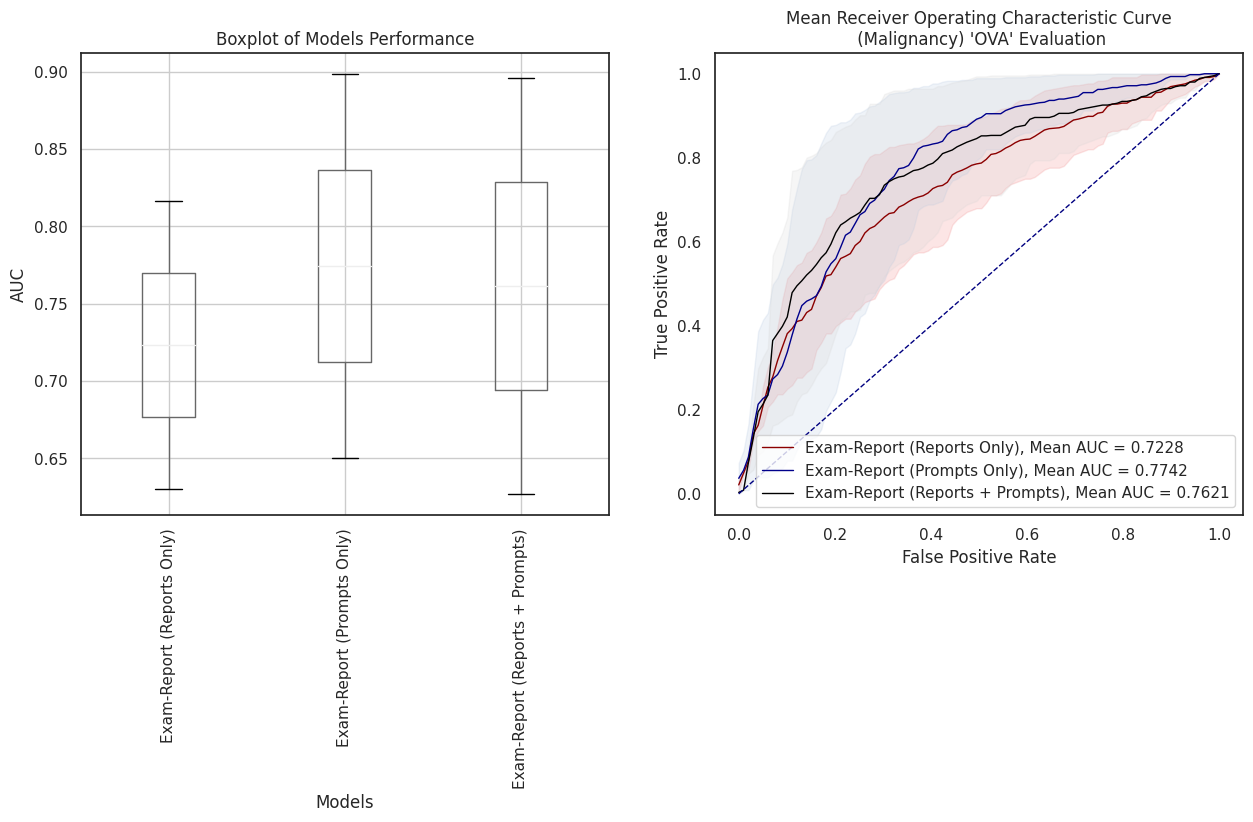

In [7]:
# evaluating exam-report combinations

evaluation_config = {
    "seed": 42,
    "evaluation": {
        "type": "ova",    # one of ["ova", "zeroshot_label_prompt"]
        "zeroshot_use_logits": True         # only used with zeroshot evaluation
    },
    "experiments":[
        {
            "path": "2024-04-29/09-30-03",
            "legend_label": "Exam-Report (Reports Only)",
            "line_color": "darkred",
            "fill_color": "lightcoral",
            "cnn_eval": False
        },
        {
            "path": "2024-04-29/10-17-33",
            "legend_label": "Exam-Report (Prompts Only)",
            "line_color": "darkblue",
            "fill_color": "lightsteelblue",
            "cnn_eval": False
        },
        {
            "path": "2024-04-29/10-05-41",
            "legend_label": "Exam-Report (Reports + Prompts)",
            "line_color": "black",
            "fill_color": "lightgray",
            "cnn_eval": False
        },
    ],
    "dataset": {
        "name": "ImageLabelDataset",        # one of ["ImageLabelDataset"]
        "enum_classes": ['BenignMalignantDatasetLabels']
    },
    "plot_title": "Mean Receiver Operating Characteristic Curve\n (Malignancy) 'OVA' Evaluation",
    "config_dir": "../outputs/"
}

compare_models_performance(evaluation_config)